# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [44]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [45]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: y_random хранит вероятности принадлежности объекта к классу 1

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [46]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


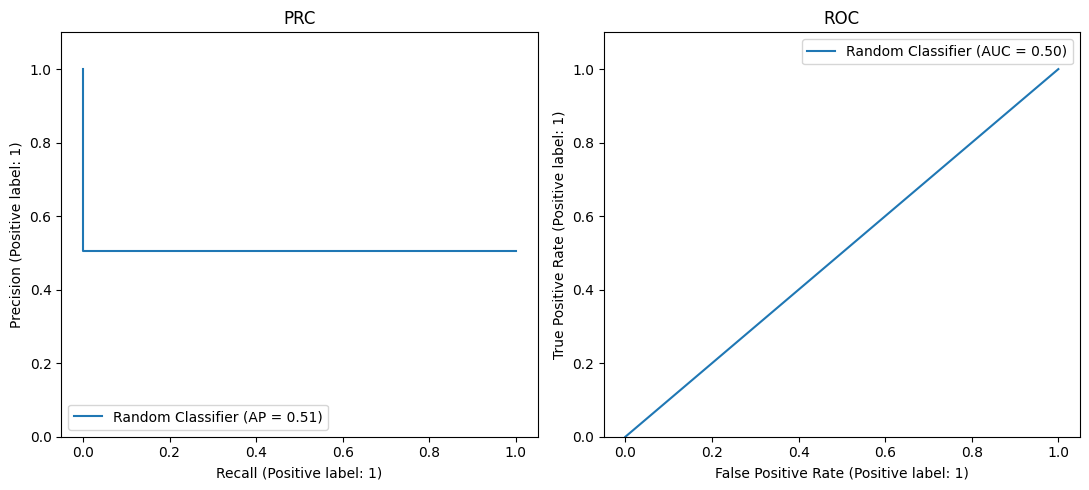

In [47]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [48]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

AUC_PR  AUC_ROC  reg_const
Random Classifier  0.752833      0.5        0.0

__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [49]:
#your code here
import sklearn.svm as svm
from sklearn.model_selection import GridSearchCV

In [50]:
regularizators = np.logspace(-1, 4, 20)
searcher = GridSearchCV(svm.LinearSVC(), [{"C": regularizators}],
                        scoring="average_precision", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` i

GridSearchCV(cv=10, estimator=LinearSVC(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-01, 1.83298071e-01, 3.35981829e-01, 6.15848211e-01,
       1.12883789e+00, 2.06913808e+00, 3.79269019e+00, 6.95192796e+00,
       1.27427499e+01, 2.33572147e+01, 4.28133240e+01, 7.84759970e+01,
       1.43844989e+02, 2.63665090e+02, 4.83293024e+02, 8.85866790e+02,
       1.62377674e+03, 2.97635144e+03, 5.45559478e+03, 1.00000000e+04])}],
             scoring='average_precision')

In [51]:
best_reg = searcher.best_params_["C"]
print("Best regularization coefficient = %.4f" % best_reg)

Best regularization coefficient = 0.1000


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [52]:
#your code here

model_svm = svm.SVC(C=best_reg, kernel='linear', probability=True)
model_svm = model_svm.fit(X_train, y_train)
probs = model_svm.predict_proba(X_test)[:,1]

SVM metrics
AUC-PR: 0.81492
AUC-ROC: 0.84792


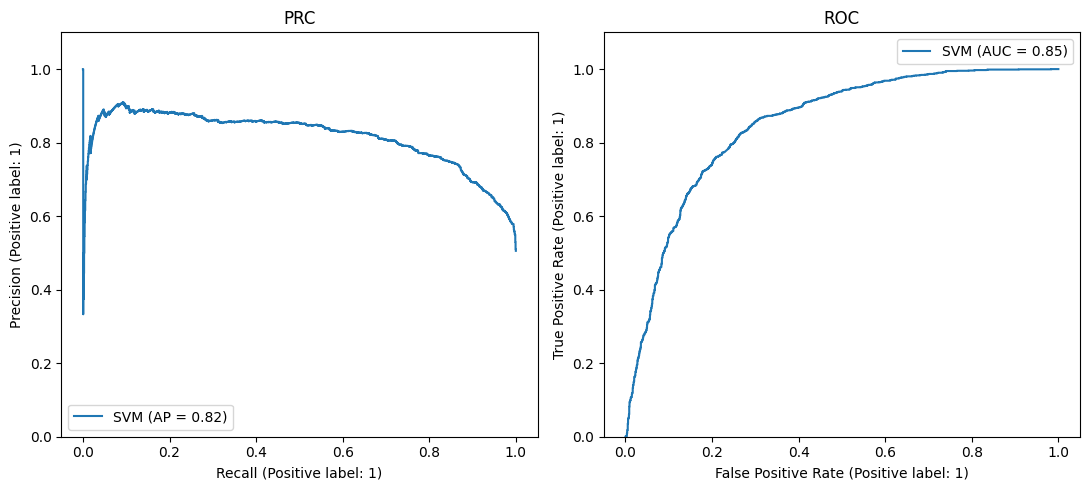

In [53]:
depict_pr_roc(y_test, probs, 'SVM')

In [54]:
precision, recall, _ = precision_recall_curve(y_test, probs)
df_metrics.loc['SVM'] = [
      auc(recall, precision),
      roc_auc_score(y_test, probs),
      best_reg
]

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


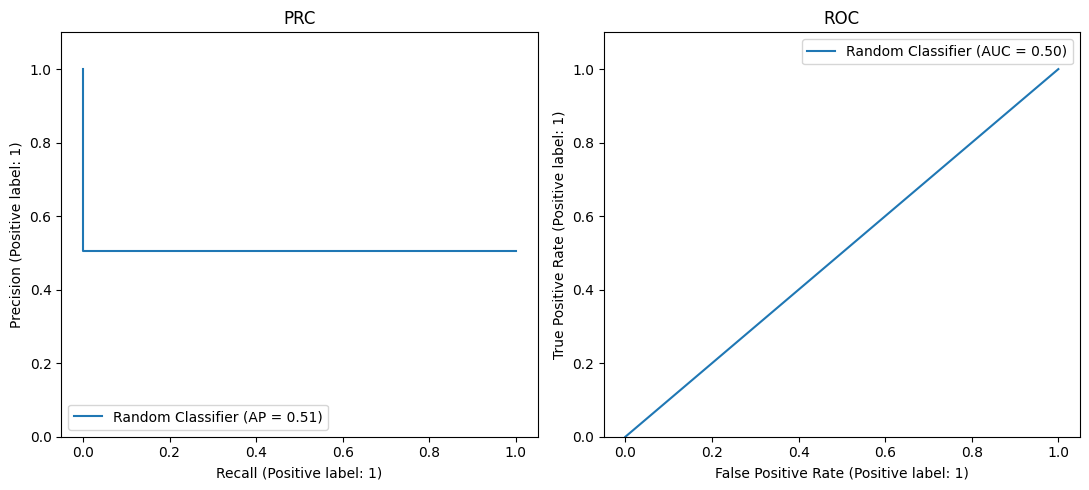

In [55]:
#your code here
depict_pr_roc(y_test, y_random, 'Random Classifier')

In [56]:
df_metrics

AUC_PR   AUC_ROC  reg_const
Random Classifier  0.752833  0.500000        0.0
SVM                0.814918  0.847916        0.1

AUC-ROC значительно вырос, тогда как PRC - не сильно.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [57]:
#your code here
from sklearn.linear_model import LogisticRegression

In [58]:
regularizators = np.logspace(-1, 4, 20)
searcher = GridSearchCV(LogisticRegression(), [{"C": regularizators}],
                        scoring="average_precision", cv=10, n_jobs=-1)
cv_results = searcher.fit(X_train, y_train)

In [59]:
best_reg = searcher.best_params_["C"]
print("Best regularization coefficient = %.4f" % best_reg)

Best regularization coefficient = 0.1000


In [60]:
model_logistic = LogisticRegression(C=best_reg)
model_logistic = model_logistic.fit(X_train, y_train)
probs_logistic = model_logistic.predict_proba(X_test)[:,1]

Logistic Regression metrics
AUC-PR: 0.82917
AUC-ROC: 0.84785


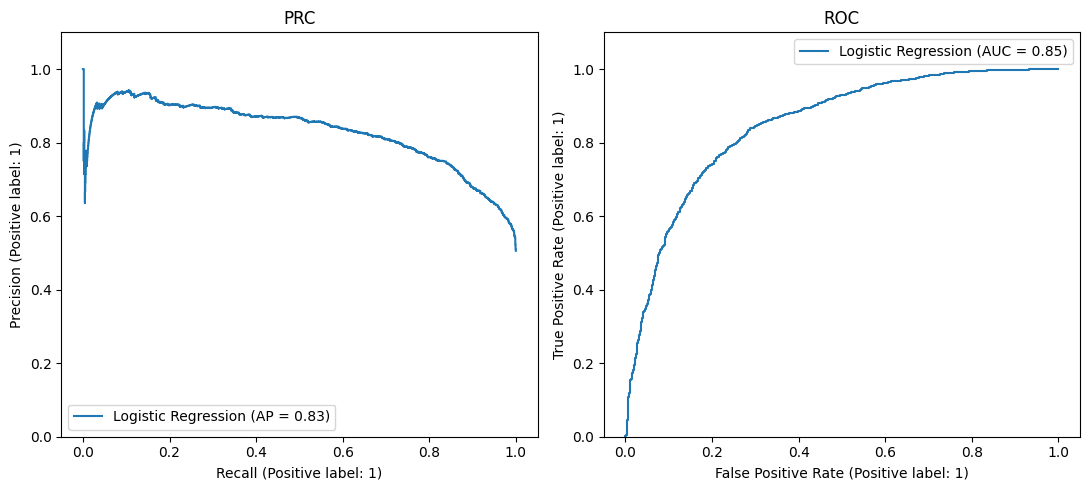

In [64]:
depict_pr_roc(y_test, probs_logistic, 'Logistic Regression')

In [62]:
precision, recall, _ = precision_recall_curve(y_test, probs_logistic)
df_metrics.loc['Logistic regression'] = [
      auc(recall, precision),
      roc_auc_score(y_test, probs_logistic),
      best_reg
]

In [63]:
df_metrics

AUC_PR   AUC_ROC  reg_const
Random Classifier    0.752833  0.500000        0.0
SVM                  0.814918  0.847916        0.1
Logistic regression  0.829168  0.847846        0.1

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Logistic Regression metrics
AUC-PR: 0.82917
AUC-ROC: 0.84785
SVM metrics
AUC-PR: 0.81492
AUC-ROC: 0.84792
Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


/var/folders/r_/6zkqdcns4cx1r5b9lksfjkkc0000gn/T/ipykernel_88910/2933229378.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/r_/6zkqdcns4cx1r5b9lksfjkkc0000gn/T/ipykernel_88910/2933229378.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


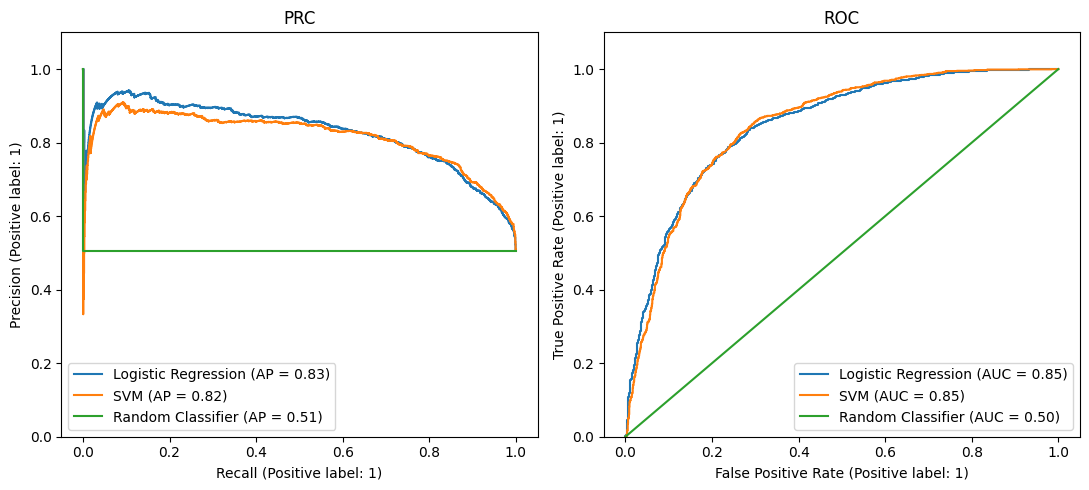

In [65]:
#your code here
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
_ = depict_pr_roc(y_test, probs_logistic, 'Logistic Regression', ax=ax)
_ = depict_pr_roc(y_test, probs, 'SVM', ax=ax)
_ = depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:**
Логистическая регрессия даёт лучший precision при более низком recall, при этом при более высоком recall SVM показывает лучший precision

Логистическая регрессия предсказывает вероятности лучше, чем SVM, но при этом в терминах AUC-ROC обе модели показывают одинаковый скор

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [70]:
#your code here
X_visual, y_visual = make_classification(n_samples=10000, n_features=2, n_informative=2,
                                         n_redundant=0, random_state=42)
svm_visual = svm.SVC(kernel='linear', probability=True)
svm_visual = svm_visual.fit(X_visual, y_visual)

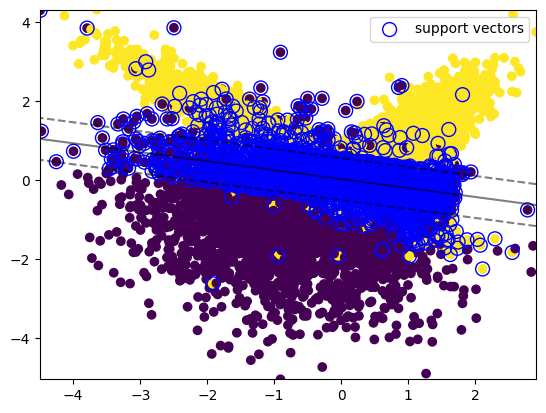

In [78]:
def plot_svm_2D(X, y, model, plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape((30, 30))

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()


plot_svm_2D(X_visual, y_visual, svm_visual)

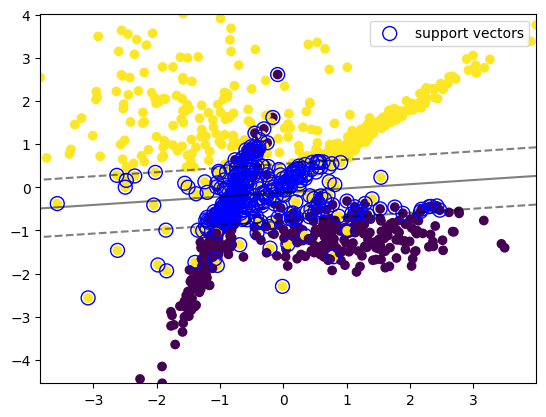

In [ ]:
def plot_svm_2D(X, y, model, plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.predict(X)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X, c=y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_,
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X_visual, y_visual, svm_visual)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Объекты, которые либо слишком близко лежат к границе, либо те, которые отнесеные не к своему классу

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

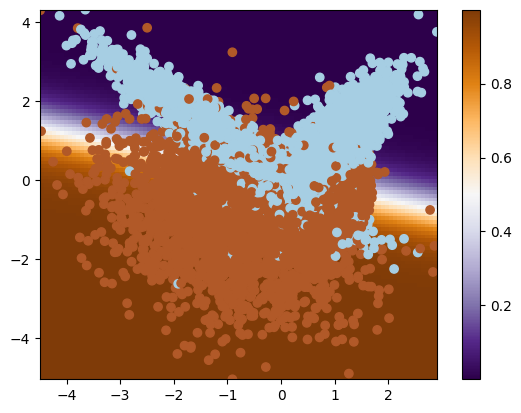

In [93]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 0].reshape((100, 100))
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=1 - y, cmap=plt.cm.Paired)

    plt.colorbar(image)


logreg_visual = LogisticRegression()
logreg_visual = logreg_visual.fit(X_visual, y_visual)

plot_logreg_2D(X_visual, y_visual, logreg_visual)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Белая полоска посередине: теоретически можно объяснить тем, что точки лежат очень близко к разделяющией гиперплоскости, поэтому значение решающей функции близко к нулю $\implies$ значение вероятности близко к $\frac{1}{2}$

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [110]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [94]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=52)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

In [96]:
model_svm = svm.SVC(kernel='linear', probability=True)
model_svm = model_svm.fit(X_train, y_train)
probs_svm = model_svm.predict_proba(X_test)[:,1]
model_logistic = LogisticRegression()
model_logistic = model_logistic.fit(X_train, y_train)
probs_logistic = model_logistic.predict_proba(X_test)[:,1]

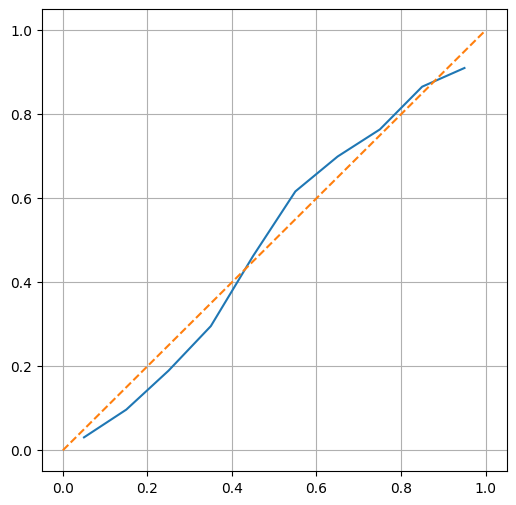

In [112]:
#your code here
plot_calibration_curve(y_test, probs_svm)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--')

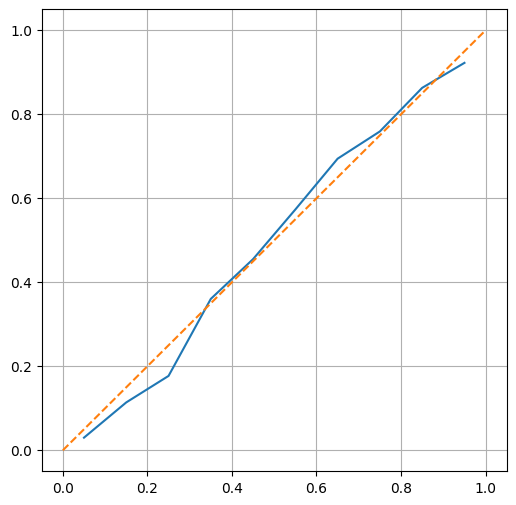

In [113]:
plot_calibration_curve(y_test, probs_logistic)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--')

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** #your answer here

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

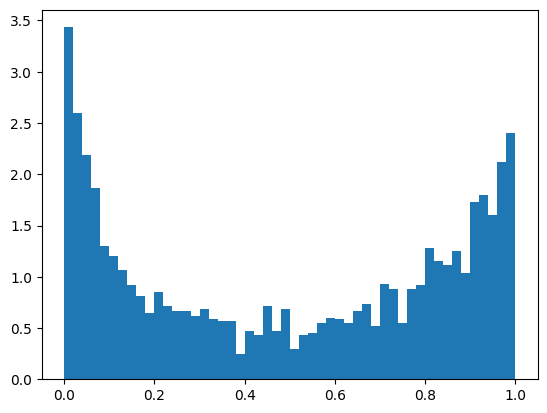

In [118]:
#your code here
plt.hist(probs_svm, density=True, bins=50);

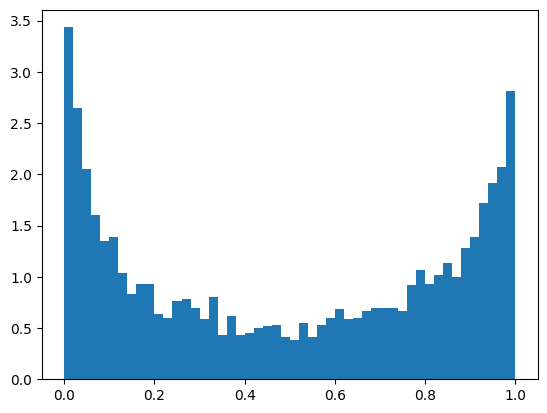

In [119]:
plt.hist(probs_logistic, density=True, bins=50);

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Видим, что SVM боле уверен в своих предсказаниях (меньше объектов в районе 0.5), что можно объяснить тем, что SVM пытается линейно разделить выборку лучшим способом, когда как логистическаяя регрессия - наиболее лучшим способом предсказывать принадлежность конкретного объекта к какому-то из классов

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [120]:
from sklearn.calibration import CalibratedClassifierCV

In [127]:
#your code here
calibrator_svm = CalibratedClassifierCV(model_svm, cv=10, n_jobs=-1)
calibration_results = calibrator_svm.fit(X_train, y_train)

In [128]:
probs_calibrated = calibration_results.predict_proba(X_test)

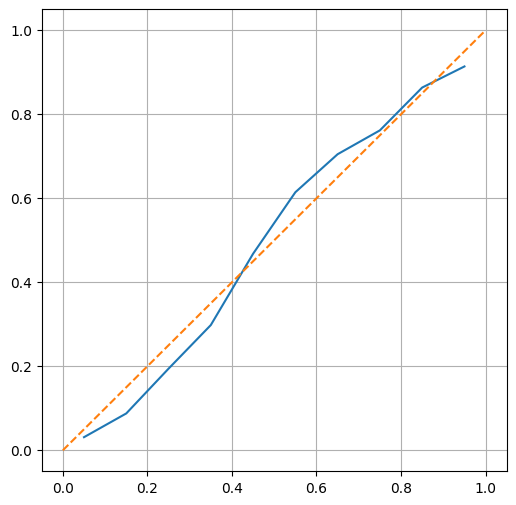

In [129]:
plot_calibration_curve(y_test, probs_calibrated[:, 1])
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--');

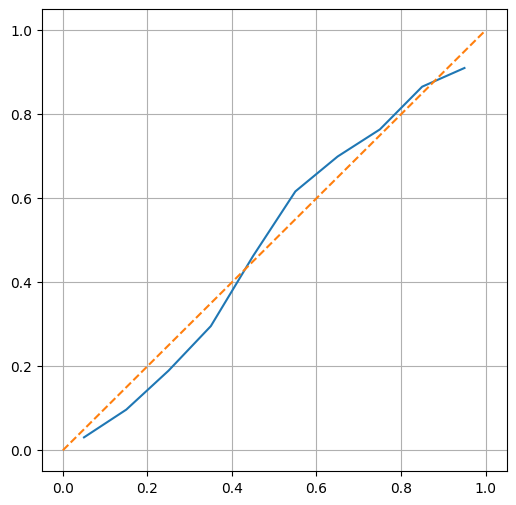

In [130]:
plot_calibration_curve(y_test, probs_svm)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--')

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Нет

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [201]:
df = pd.read_csv('bike_buyers.csv')
#Заменим пропуски категориальных переменных
#your code here

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = X[['Income', 'Children', 'Cars', 'Age']]
X_categorical = X.drop(columns=['Income', 'Children', 'Cars', 'Age', 'ID']).fillna('undefined')

In [202]:
X_categorical

Marital Status     Gender        Education      Occupation Home Owner  \
0          Married     Female        Bachelors  Skilled Manual        Yes   
1          Married       Male  Partial College        Clerical        Yes   
2          Married       Male  Partial College    Professional         No   
3           Single  undefined        Bachelors    Professional        Yes   
4           Single       Male        Bachelors        Clerical         No   
..             ...        ...              ...             ...        ...   
995        Married       Male      High School    Professional        Yes   
996         Single       Male  Graduate Degree    Professional        Yes   
997        Married  undefined        Bachelors  Skilled Manual        Yes   
998         Single       Male        Bachelors      Management         No   
999         Single       Male      High School    Professional        Yes   

    Commute Distance         Region  
0          0-1 Miles         Europe  
1          0-1 Miles         Europe  
2          2-5 Miles         Europe  
3         5-10 Miles        Pacific  
4          0-1 Miles         Europe  
..               ...            ...  
995        2-5 Miles  North America  
996        2-5 Miles  North America  
997        0-1 Miles  North America  
998        1-2 Miles  North America  
999        10+ Miles  North America  

[1000 rows x 7 columns]

В начале поработаем только с категориальными признаками

In [203]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [375]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [376]:
from datetime import datetime
from typing import TypeVar, cast
from typing_extensions import ParamSpec

P = ParamSpec('P')
T = TypeVar('T')


def profiler(func):  # type: ignore
    """
    Returns profiling decorator, which counts calls of function
    and measure last function execution time.
    Results are stored as function attributes: `calls`, `last_time_taken`
    :param func: function to decorate
    :return: decorator, which wraps any function passed
    """
    balance = 0
    start = 0
    calls = 0

    def wrapper(*args: P.args, **kwargs: P.kwargs) -> T:  # type: ignore
        nonlocal balance, start, calls
        if 'calls' not in wrapper.__globals__:
            wrapper.calls: int = 0  # type: ignore
        if "last_time_taken" not in wrapper.__globals__:
            wrapper.last_time_taken: float = 0  # type: ignore
        if balance == 0:
            start = datetime.now()
            func.calls = 0
            func.last_time_taken = 0
            calls = 0
        balance += 1
        calls += 1
        ans = func(*args, **kwargs)
        balance -= 1
        if balance == 0:
            wrapper.last_time_taken = (datetime.now() - start).total_seconds()  # type: ignore
            wrapper.calls = calls  # type: ignore
        return cast(T, ans)

    wrapper.__name__ = func.__name__
    wrapper.__doc__ = func.__doc__
    wrapper.__module__ = func.__module__
    return wrapper


In [377]:
@profiler
def transform_train(transformer, model, X_train, y_train):
    X_train_ordinal = transformer.fit_transform(X_train, y=y_train)
    model = model.fit(X_train_ordinal, y_train)
    return transformer, model

In [378]:
#your code here

trans_ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
model_ordinal = LogisticRegression()
trans_ordinal, model_ordinal = transform_train(trans_ordinal, model_ordinal, X_train, y_train)

In [379]:
print('PR-AUC for the OrdinalEncoder:', average_precision_score(y_test, model_ordinal.predict(trans_ordinal.transform(X_test))))
print('Time for the OrdinalEncoder pipeline:', transform_train.last_time_taken)

PR-AUC for the OrdinalEncoder: 0.5047411003236246
Time for the OrdinalEncoder pipeline: 0.031345


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [380]:
#your code here
trans_onehot = OneHotEncoder(handle_unknown='ignore')
model_onehot = LogisticRegression()
trans_onehot, model_onehot = transform_train(trans_onehot, model_onehot, X_train, y_train)

In [381]:
print('PR-AUC for the OneHotEncoder:', average_precision_score(y_test, model_onehot.predict(trans_onehot.transform(X_test))))
print('Time for the OneHotEncoder pipeline:', transform_train.last_time_taken)

PR-AUC for the OneHotEncoder: 0.5611792717086835
Time for the OneHotEncoder pipeline: 0.028461


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [436]:
#your code here
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

class MeanTargetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, list_cols=None, noising=False, mixturing=0):
        if list_cols is None:
            self.list_cols = []
        else:
            self.list_cols = list_cols
        self.col_means = dict()
        self.col_name = ''
        self.noising = noising
        self.mixturing = mixturing

    def fit(self, X=None, y=None):
        self.y = y
        if X is None:
            return self
        for col in self.list_cols:
            groups_col = pd.concat([X[col], y], axis=1).groupby(col)[y.name]
            self.col_means[col] = (groups_col.sum() + self.mixturing 
                                   * y.mean()) / (groups_col.count() + self.mixturing)
            if self.noising:
                self.col_means[col] += np.random.random(self.col_means[col].shape[0])
        self.col_name = y.name
        return self

    def transform(self, X, y=None):
        # your code here
        X_new = X.copy()
        for col, means_col in self.col_means.items():
            X_new[col] = X[col].map(means_col).fillna(self.y.mean())
        return X_new

In [383]:
trans_mte = MeanTargetTransformer(list(X_train.columns))
model_mte = LogisticRegression()
trans_mte, model_mte = transform_train(trans_mte, model_mte, X_train, y_train)

In [384]:
print('PR-AUC for the MTE:', average_precision_score(y_test, model_mte.predict(trans_mte.transform(X_test))))
print('Time for the MTE pipeline:', transform_train.last_time_taken)

PR-AUC for the MTE: 0.5460522875816993
Time for the MTE pipeline: 0.050304


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [385]:
#your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [386]:
#your code here
trans_mte_noise = MeanTargetTransformer(list(X_train.columns), True)
model_mte_noise = LogisticRegression()
trans_mte_noise, model_mte_noise = transform_train(trans_mte_noise, model_mte_noise, X_train, y_train)

In [387]:
print('PR-AUC for the MTE:', average_precision_score(y_test, model_mte_noise.predict(trans_mte_noise.transform(X_test))))
print('Time for the MTE pipeline:', transform_train.last_time_taken)

PR-AUC for the MTE: 0.4949393939393939
Time for the MTE pipeline: 0.065651


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шума не увеличило PR-AUC, потому что ???

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [388]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [430]:
#your code here
trans_mte_smoothing = MeanTargetTransformer(list(X_train.columns), True, 96)
model_mte_smoothing = LogisticRegression()
trans_mte_smoothing, model_mte_smoothing = transform_train(trans_mte_smoothing, model_mte_smoothing, X_train, y_train)
print('PR-AUC for the MTE:', average_precision_score(y_test, model_mte_smoothing.predict(trans_mte_smoothing.transform(X_test))))
print('Time for the MTE pipeline:', transform_train.last_time_taken)

PR-AUC for the MTE: 0.5670617283950617
Time for the MTE pipeline: 0.029145


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [431]:
#your code here
X_numerical = X_numerical.fillna(X_numerical.mean(axis=0))

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [437]:
#your code here
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(pd.concat([X_categorical, X_numerical], axis=1), y, test_size=0.25, random_state=777, stratify=y)

In [438]:
print(X_train_full)

    Marital Status  Gender            Education      Occupation Home Owner  \
345        Married  Female            Bachelors        Clerical        Yes   
540         Single  Female      Graduate Degree      Management        Yes   
110         Single  Female      Partial College          Manual         No   
902         Single    Male            Bachelors  Skilled Manual        Yes   
15          Single  Female          High School          Manual        Yes   
..             ...     ...                  ...             ...        ...   
483        Married    Male      Graduate Degree        Clerical        Yes   
375        Married  Female            Bachelors  Skilled Manual        Yes   
968         Single    Male  Partial High School        Clerical         No   
756        Married    Male            Bachelors  Skilled Manual         No   
883        Married  Female            Bachelors    Professional        Yes   

    Commute Distance         Region        Income  Children  Ca

In [462]:
trans_mte_full = MeanTargetTransformer(list(X_train_full.columns), noising=True, mixturing=10)
model_mte_full = LogisticRegression()
trans_mte_full, model_mte_full = transform_train(trans_mte_full, model_mte_full, X_train_full, y_train_full)

In [463]:
print('PR-AUC for the MTE:', average_precision_score(y_test_full, model_mte_full.predict(trans_mte_full.transform(X_test_full))))
print('Time for the MTE pipeline:', transform_train.last_time_taken)

PR-AUC for the MTE: 0.5233125000000001
Time for the MTE pipeline: 0


Теперь по отдельности попербираем численные признаки и посмотрим на перформанс модели при MTE одного из численных признаков

In [467]:
aur_prs = dict()
times = dict()
for num_feature in ['Income', 'Children', 'Cars', 'Age']:
    auc_pr_arr_feature = []
    times_feature = []
    for _ in range(10):
        trans_mte_partial_i = MeanTargetTransformer(list(X_train.columns) + [num_feature], noising=True, mixturing=10)
        model_mte_partial_i = LogisticRegression()
        trans_mte_partial_i, model_mte_partial_i = transform_train(trans_mte_partial_i, model_mte_partial_i, X_train_full, y_train_full)
        auc_pr_arr_feature.append(average_precision_score(y_test, model_mte_smoothing.predict(trans_mte_smoothing.transform(X_test))))
        times_feature.append(transform_train.last_time_taken)
    aur_prs[num_feature] = np.mean(auc_pr_arr_feature)
    times[num_feature] = np.mean(times_feature)

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

In [469]:
for num_feature in aur_prs.keys():
    print(f'PR-AUC for the MTE w/ encoded {num_feature} feature:', aur_prs[num_feature])
    print('Time for the MTE pipeline w/ encoded {num_feature} feature:', times[num_feature])
    print('----------')

PR-AUC for the MTE w/ encoded Income feature: 0.5670617283950616
Time for the MTE pipeline w/ encoded {num_feature} feature: 0.0
----------
PR-AUC for the MTE w/ encoded Children feature: 0.5670617283950616
Time for the MTE pipeline w/ encoded {num_feature} feature: 0.0
----------
PR-AUC for the MTE w/ encoded Cars feature: 0.5670617283950616
Time for the MTE pipeline w/ encoded {num_feature} feature: 0.0
----------
PR-AUC for the MTE w/ encoded Age feature: 0.5670617283950616
Time for the MTE pipeline w/ encoded {num_feature} feature: 0.0
----------


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ ОН кодирование плохо себя показывает, когда у нас слишком много различных значений признака, а уж тем более когда определенных значений крайне мало (переобучаемся на этот признак), в итоге имеем проблемы со скоростью обучения и памятью. 

Минус MTE в том, что если у нас тестовая выборка смещена относительно тренировочной, то мы сами себя обманываем и обучаемся на признаке, который на тесте не так сильно кореллирует с таргетом, а также чаще всего приходится придумывать костыли, чтобы не допустить утечку целевой переменной (что не спасает полностью от этой пробоемы).

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [470]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

zsh:1: command not found: wget


In [481]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

age   workclass  fnlwgt   education  education-num  \
16915   30   Local-gov   44566   Bachelors             13   

            marital-status       occupation relationship    race    sex  \
16915   Married-civ-spouse   Prof-specialty      Husband   White   Male   

       capital-gain  capital-loss  hours-per-week  native-country  income  
16915             0             0              80   United-States       0

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [484]:
y = df['income']
X = df.drop(columns=['income'])

In [554]:
#your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [555]:
#your code here
categorical = ['workclass', 'education', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'hours-per-week', 'native-country']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
])

print('Before OHE:', len(X.columns))
X_train_encoded = column_transformer.fit_transform(X_train)
print('After OHE:', X_train_encoded.shape[1])

Before OHE: 14
After OHE: 194


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [558]:
#your code here
model_baseline = LogisticRegression()
model_baseline = model_baseline.fit(X_train_encoded, y_train)
auc_pr_baseline = average_precision_score(y_test, model_baseline.predict(column_transformer.transform(X_test)))

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [559]:
print(f'PR-AUC of baseline solution:', auc_pr_baseline)

PR-AUC of baseline solution: 0.48903021096322774


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [560]:
#your code here

best_params = sorted((zip((np.abs(model_baseline.coef_.reshape((-1, )))), range(X_train_encoded.shape[1]))), reverse=True)[:40]

In [561]:
best_params_indices = list(i[1] for i in best_params)

In [562]:
model_abs_best_features = LogisticRegression()
model_abs_best_features = model_abs_best_features.fit(X_train_encoded[:, best_params_indices], y_train)
auc_pr_abs_best_features = average_precision_score(y_test, model_abs_best_features.predict(column_transformer.transform(X_test)[:, best_params_indices]))

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [563]:
print(f'PR-AUC of shortened solution:', auc_pr_abs_best_features)

PR-AUC of shortened solution: 0.46578717188817226


Изменилось ли качество? Как?

Качество немного ухудшилось

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [564]:
from sklearn.preprocessing import StandardScaler

In [582]:
#your code here
categorical = ['workclass', 'education', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
numeric = ['age', 'fnlwgt',
           'education-num', 'capital-gain',
           'capital-loss']

column_transformer_rescaled = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

X_train_rescaled = column_transformer_rescaled.fit_transform(X_train)
model_rescaled = LogisticRegression()
model_rescaled = model_rescaled.fit(X_train_rescaled, y_train)
best_params_rescaled = sorted((zip((np.abs(model_rescaled.coef_.reshape((-1, )))), range(X_train_rescaled.shape[1]))), reverse=True)[:40]
best_params_rescaled_indices = list(i[1] for i in best_params_rescaled)
model_abs_best_features_rescaled = LogisticRegression()
model_abs_best_features_rescaled = model_abs_best_features_rescaled.fit(X_train_rescaled[:, best_params_rescaled_indices], y_train)
auc_pr_abs_best_features_rescaled = average_precision_score(y_test, model_abs_best_features_rescaled.predict(column_transformer_rescaled.transform(X_test)[:, best_params_rescaled_indices]))

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [583]:
print(f'PR-AUC of shortened solution w/ scaling:', auc_pr_abs_best_features_rescaled)

PR-AUC of shortened solution w/ scaling: 0.42791473645785416


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [584]:
from sklearn.compose import make_column_selector

In [585]:
#your code here
column_transformer_ohe = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical)
])

X_encoded_idk = column_transformer_ohe.fit_transform(X_train)

column_transformer_scale = ColumnTransformer([
    ('scaling', StandardScaler(), slice(X_encoded_idk.shape[1]))
])

X_train_rescaled = column_transformer_scale.fit_transform(X_encoded_idk)
model_rescaled = LogisticRegression()
model_rescaled = model_rescaled.fit(X_train_encoded, y_train)
best_params_rescaled = sorted((zip((np.abs(model_rescaled.coef_.reshape((-1, )))), range(X_train_rescaled.shape[1]))), reverse=True)[:40]
best_params_rescaled_all_indices = list(i[1] for i in best_params_rescaled)
model_abs_best_features_rescaled = LogisticRegression()
model_abs_best_features_rescaled = model_abs_best_features_rescaled.fit(X_train_encoded[:, best_params_rescaled_all_indices], y_train)
auc_pr_abs_best_features_rescaled_all = average_precision_score(y_test, model_abs_best_features_rescaled.predict(column_transformer_scale.transform(column_transformer_ohe.transform(X_test))[:, best_params_rescaled_all_indices]))

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

In [586]:
print(f'PR-AUC of shortened solution w/ scaling everything:', auc_pr_abs_best_features_rescaled)

PR-AUC of shortened solution w/ scaling everything: 0.42791473645785416


In [587]:
print(len(set(best_params_rescaled_indices).symmetric_difference(best_params_rescaled_all_indices)))

24


Качество не изменилось, признаки поменялись

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [603]:
#your code here

def t_statistic(x, y):
    mean_positive = x[y == 1].mean()
    mean_negative = x[y == 0].mean()
    var_positive = x[y == 1].var()
    var_negative = x[y == 0].var()
    num_positive = y[y == 1].count()
    num_negative = y[y == 0].count()
    return np.abs(mean_positive - mean_negative) / np.sqrt((var_positive * num_positive + var_negative * num_negative) / (y.shape[0]))

In [604]:
column_transformer_rescaled = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

X_train_rescaled = column_transformer_rescaled.fit_transform(X_train)
best_params_t = sorted((zip((t_statistic(X_train_rescaled[:, i].todense(), y_train) for i in range(X_train_rescaled.shape[1])), range(X_train_rescaled.shape[1]))), reverse=True)[:40]
best_params_t_indices = list(i[1] for i in best_params_rescaled)

In [605]:
model_t = LogisticRegression()
model_t = model_t.fit(X_train_rescaled[:, best_params_t_indices], y_train)
auc_pr_t = average_precision_score(y_test, model_t.predict(column_transformer_rescaled.transform(X_test)[:, best_params_t_indices]))

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [606]:
print(f'PR-AUC of shortened solution w/ t-statistic:', auc_pr_t)

PR-AUC of shortened solution w/ t-statistic: 0.46578717188817226


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [617]:
#your code here
X_train_copied = X_train_rescaled.copy()
X_test_copied = column_transformer_rescaled.transform(X_test).copy()
X_train_copied, X_val_copied, y_train_copied, y_val_copied = train_test_split(X_train_copied, y_train, test_size=0.25, random_state=777, stratify=y_train)

features_num = X_train_copied.shape[1]
features_indices = list(range(features_num))
for j in range(features_num, 40, -1):
    scores = []
    for i in range(X_train_copied.shape[1]):
        X_train_drop_i = X_train_copied[:, list(range(X_train_copied.shape[1])).pop(i)]
        X_val_drop_i = X_val_copied[:, list(range(X_train_copied.shape[1])).pop(i)]
        model_drop_i = LogisticRegression()
        model_drop_i = model_drop_i.fit(X_train_drop_i, y_train_copied)
        auc_pr_drop_i = average_precision_score(y_val_copied, model_drop_i.predict(X_val_drop_i))
        scores.append(auc_pr_drop_i)
    worst_feature = np.argmax(scores)
    features_indices.pop(worst_feature)
    features_indices_norm = list(range(X_train_copied.shape[1])).pop(worst_feature)
    X_train_copied = X_train_copied[:, features_indices_norm]
    X_val_copied = X_val_copied[:, features_indices_norm]
    print(j - 1, 'features left')
    

198 features left
197 features left
196 features left
195 features left
194 features left
193 features left
192 features left
191 features left
190 features left
189 features left
188 features left
187 features left
186 features left
185 features left
184 features left
183 features left
182 features left
181 features left
180 features left
179 features left
178 features left
177 features left
176 features left
175 features left
174 features left
173 features left
172 features left
171 features left
170 features left
169 features left
168 features left
167 features left
166 features left
165 features left
164 features left
163 features left
162 features left
161 features left
160 features left
159 features left
158 features left
157 features left
156 features left
155 features left
154 features left
153 features left
152 features left
151 features left
150 features left
149 features left
148 features left
147 features left
146 features left
145 features left
144 features left
143 featur

Отбор прошел быстро, 3-4 секунды

In [618]:
model_dropoff = LogisticRegression()
model_dropoff = model_dropoff.fit(X_train_rescaled[:, features_indices], y_train)
auc_pr_dropoff = average_precision_score(y_test, model_dropoff.predict(column_transformer_rescaled.transform(X_test)[:, features_indices]))

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [619]:
print(f'PR-AUC of shortened solution w/ features drop:', auc_pr_dropoff)

PR-AUC of shortened solution w/ features drop: 0.33860120160169294


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [634]:
#your code here
X_train_copied = np.asarray(X_train_rescaled.copy().todense())
X_test_copied = np.asarray(column_transformer_rescaled.transform(X_test).copy().todense())
X_train_copied, X_val_copied, y_train_copied, y_val_copied = train_test_split(X_train_copied, y_train, test_size=0.25, random_state=777, stratify=y_train)

features_num = X_train_copied.shape[1]
features_indices_add = list(range(features_num))
X_start_train = None
X_start_val = None
scores = []
avaliable_features = set(range(X_train_copied.shape[1]))
for j in range(0, 40, 1):
    scores_j = []
    for i in avaliable_features:
        if X_start_train is None:
            X_train_add_i = X_train_copied[:, i].reshape((-1, 1))
            X_val_add_i = X_val_copied[:, i].reshape((-1, 1))
        else:
            X_train_add_i = np.hstack((X_start_train, X_train_copied[:, i].reshape((-1, 1))))
            X_val_add_i = np.hstack((X_start_val, X_val_copied[:, i].reshape((-1, 1))))
        model_add_i = LogisticRegression()
        model_add_i = model_add_i.fit(X_train_add_i, y_train_copied)
        auc_pr_add_i = average_precision_score(y_val_copied, model_add_i.predict(X_val_add_i))
        scores_j.append(auc_pr_add_i)
    best_score, best_feature = max(zip(scores_j, sorted(avaliable_features)))
    scores.append(best_score)
    avaliable_features.remove(best_feature)
    if X_start_train is None:
        X_start_train = X_train_copied[:, best_feature].reshape((-1, 1))
        X_start_val = X_val_copied[:, best_feature].reshape((-1, 1))
    else:
        X_start_train = np.hstack((X_start_train, X_train_copied[:, best_feature].reshape((-1, 1))))
        X_start_val = np.hstack((X_start_val, X_val_copied[:, best_feature].reshape((-1, 1))))
    features_indices_add.append(best_feature)
    print(j + 1, 'features in')
    

1 features in
2 features in
3 features in
4 features in
5 features in
6 features in
7 features in
8 features in
9 features in
10 features in
11 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

12 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

13 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

14 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

15 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

16 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

17 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

18 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

19 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

20 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

21 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

22 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

23 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

24 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

25 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

26 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

27 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

28 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

29 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

30 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

31 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

32 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

33 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

34 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

35 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

36 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

37 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

38 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

39 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

40 features in


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0, 0.5, 'PR-AUC')

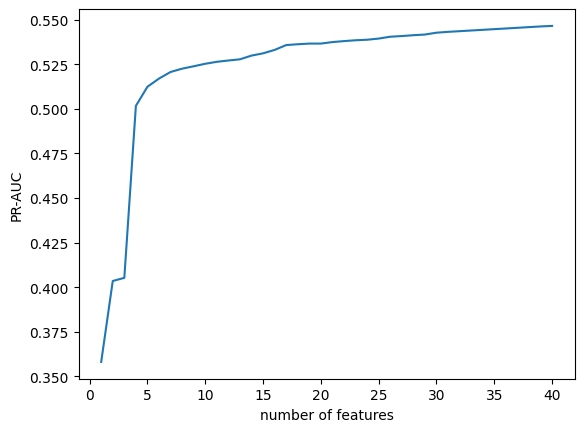

In [711]:
plt.plot(range(1, 41), scores)
plt.xlabel("number of features")
plt.ylabel("PR-AUC")

Видим, что зависимость PR-AUC от кол-ва добавленных признаков - монотонно возрастающая

In [635]:
model_add = LogisticRegression()
model_add = model_add.fit(X_train_rescaled[:, features_indices_add], y_train)
auc_pr_add = average_precision_score(y_test, model_add.predict(column_transformer_rescaled.transform(X_test)[:, features_indices_add]))

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [637]:
print(f'PR-AUC of shortened solution w/ features drop:', auc_pr_add)

PR-AUC of shortened solution w/ features drop: 0.5362965105249096


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Самый лучший из способов - самый последний

Оставить признаки с самыми большими по модулю коэффициентами: плюсы - интуитивно понятно, относительно быстро, минусы - все признаки должны быть подогнаны к одному масштабу

Использовать методы фильтрации: плюсы - логично, минусы - не так эффективно

Жадно убирать признаки: плюсы - не нужно ремасшабирование и +- быстро, минусы - из-за жадности процедуры результат неконсистентен

Жадно прибавлять признаки: плюсы - эффективно, минусы - очень долго


# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [638]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

zsh:1: command not found: wget
Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [639]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93.994          -36.4      4.857       5191.0  no  
1           1.1          93.994          -36.4      4.857       5191.0  no  
2           1.1          93.994          -36.4      4.857       5191.0  no  
3           1.1          93.994          -36.4      4.857       5191.0  no  
4           1.1          93.994          -36.4      4.857       5191.0  no

In [640]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [666]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [667]:
# your code here
folder = KFold(n_splits=5, shuffle=True, random_state=500)
iter_data = folder.split(X, y)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [690]:
# your code here
categorical_columns = X.select_dtypes(include=["object"]).columns
numerical_columns = X.select_dtypes(exclude=["object"]).columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ('scaling', StandardScaler(), numerical_columns)
])

pipeline_folds = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('model', LogisticRegression())
])

In [669]:
y_test_folds = []
pred_folds = []
for train_i, test_i in iter_data:
    X_train = X.loc[train_i]
    y_train = y[train_i]
    X_test = X.loc[test_i]
    y_test = y[test_i]
    y_test_folds.append(y_test)
    model_i = pipeline_folds
    model_i = model_i.fit(X_train, y_train)
    pred_folds.append(model_i.predict(X_test))

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [680]:
# your code here
revenues = []
costs = []
for i in range(len(y_test_folds)):
    revenue_i = 10 * pred_folds[i][(y_test_folds[i] == True) & (pred_folds[i].reshape((-1, )) == True)].shape[0]
    costs_i = pred_folds[i][pred_folds[i] == True].shape[0]
    print(f'Revenue for split number {i}: {revenue_i}, costs for split number {i}: {costs_i}')
    revenues.append(revenue_i)
    costs.append(costs_i)

Revenue for split number 0: 2240, costs for split number 0: 309
Revenue for split number 1: 2110, costs for split number 1: 330
Revenue for split number 2: 2080, costs for split number 2: 328
Revenue for split number 3: 2240, costs for split number 3: 330
Revenue for split number 4: 1970, costs for split number 4: 321


In [681]:
print('Average revenue:', np.mean(revenues))
print('Average costs:', np.mean(costs))

Average revenue: 2128.0
Average costs: 323.6


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [683]:
#your code here
revenues_rndm = []
costs_rndm = []
for i in range(len(y_test_folds)):
    revenue_i = np.random.rand() * 20 * pred_folds[i][(y_test_folds[i] == True) & (pred_folds[i].reshape((-1, )) == True)].shape[0]
    costs_i = pred_folds[i][pred_folds[i] == True].shape[0]
    print(f'Revenue for split number {i}: {revenue_i}, costs for split number {i}: {costs_i}')
    revenues_rndm.append(revenue_i)
    costs_rndm.append(costs_i)

Revenue for split number 0: 1826.0642062371114, costs for split number 0: 309
Revenue for split number 1: 1875.6044760221591, costs for split number 1: 330
Revenue for split number 2: 3557.4599248183717, costs for split number 2: 328
Revenue for split number 3: 3383.997107541914, costs for split number 3: 330
Revenue for split number 4: 1581.932449814762, costs for split number 4: 321


In [685]:
print('Average revenue:', np.mean(revenues_rndm))
print('Average costs:', np.mean(costs_rndm))

Average revenue: 2445.0116328868635
Average costs: 323.6


Выручка увеличилась, что не необычно, т.к. при стремлении фолдов (и кол-ва данных) к бесконечности средняя выручка будет стремиться к изначальной детерминированной величине

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [686]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [687]:
def random_profit_score(y_true, y_pred):
    revenue = np.random.rand() * 20 * y_pred[(y_true == True) & (y_pred.reshape((-1, )) == True)].shape[0]
    costs = y_pred[y_pred == True].shape[0]
    return revenue - costs

my_scoring_func = make_scorer(random_profit_score, greater_is_better=False)

In [691]:
#your code here
folder = KFold(n_splits=5, shuffle=True, random_state=500)
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(pipeline_folds, [{"model__C": alphas}],
                        scoring=my_scoring_func, cv=folder, n_jobs=-1)

In [693]:
searcher.fit(X, y);

best_regularizator = searcher.best_params_["model__C"]

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

In [695]:
pipeline_folds = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('model', LogisticRegression(C=best_regularizator))
])

folder = KFold(n_splits=5, shuffle=True, random_state=500)
iter_data = folder.split(X, y)

y_test_folds = []
pred_folds = []
for train_i, test_i in iter_data:
    X_train = X.loc[train_i]
    y_train = y[train_i]
    X_test = X.loc[test_i]
    y_test = y[test_i]
    y_test_folds.append(y_test)
    model_i = pipeline_folds
    model_i = model_i.fit(X_train, y_train)
    pred_folds.append(model_i.predict(X_test))
revenues_rndm_new = []
costs_rndm_new = []
for i in range(len(y_test_folds)):
    revenue_i = np.random.rand() * 20 * pred_folds[i][(y_test_folds[i] == True) & (pred_folds[i].reshape((-1, )) == True)].shape[0]
    costs_i = pred_folds[i][pred_folds[i] == True].shape[0]
    print(f'Revenue for split number {i}: {revenue_i}, costs for split number {i}: {costs_i}')
    revenues_rndm_new.append(revenue_i)
    costs_rndm_new.append(costs_i)
print('Average revenue:', np.mean(revenues_rndm_new))
print('Average costs:', np.mean(costs_rndm_new))
print('Average profit:', np.mean(revenues_rndm_new) - np.mean(costs_rndm_new))
print('Average profit before hyperparameters optimization:', np.mean(revenues_rndm) - np.mean(costs_rndm))

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

Revenue for split number 0: 3887.6857719017275, costs for split number 0: 311
Revenue for split number 1: 1836.949292856917, costs for split number 1: 330
Revenue for split number 2: 702.6990186254029, costs for split number 2: 329
Revenue for split number 3: 3669.3459409711027, costs for split number 3: 332
Revenue for split number 4: 1269.890704886612, costs for split number 4: 324
Average revenue: 2273.3141458483524
Average costs: 325.2
Average profit: 1948.1141458483523
Average profit before hyperparameters optimization: 2121.4116328868636


/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0, 0.5, 'CV score')

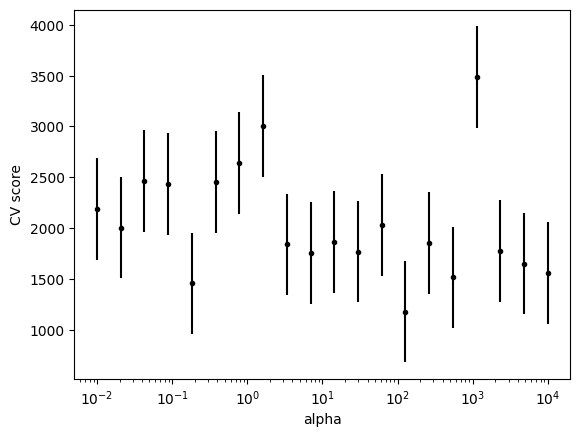

In [710]:
plt.errorbar(alphas, -searcher.cv_results_["mean_test_score"], yerr=500, fmt='.k')
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [699]:
from collections import defaultdict

In [701]:
#your code here
best_params = defaultdict(int)

for _ in range(25):
    folder = KFold(n_splits=5, shuffle=True, random_state=500)
    alphas = np.logspace(-2, 4, 20)
    searcher = GridSearchCV(pipeline_folds, [{"model__C": alphas}],
                            scoring=my_scoring_func, cv=folder, n_jobs=-1)
    searcher.fit(X, y);

    best_regularizator = searcher.best_params_["model__C"]
    best_params[best_regularizator] += 1

/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pepilica/PyCharmProjects/ml-course-hse/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

Text(0, 0.5, 'Times alpha was chosen as best hyperparameter')

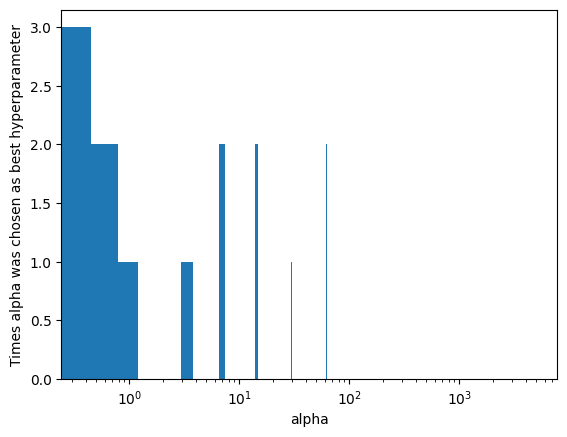

In [705]:
params_freq = best_params.items()

plt.bar(list(i[0] for i in params_freq), list(i[1] for i in params_freq))
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("Times alpha was chosen as best hyperparameter")

Видим, что какой-либо закономерности нет. Вывод - качество модели (как и подобранный коэффициент) сильно зависят от данных и фолдов, на которых мы ищем гиперпараметры.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [ ]:
#your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ #your answer here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here